In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import netCDF4 as nc
from scipy import stats
from scipy import signal
from scipy.fft import fft 
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import time

/tmp/ipykernel_47685/2652616351.py:5: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.linewidth':2}
plt.rcParams.update(parameters)

In [5]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [6]:
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #les données saisies dans Data doivent avoir 
    #la dimension n1=espace, n2=temps on initialise les matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #pour chaque point de l'espace on fait la corrélation
        #de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb a deux sorties : la première est exécutée 
        #et la seconde est p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #On génère une variable qui fait que seules les valeurs de Cor ou la corrélation
    # est significative sont affichées
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #Nous générons la carte de régression par multiplication matricielle. 
    #Attention aux dimensions !
    reg=Data.dot(Index)/ (n2-1)
    #de même, on fait un masque pour que la carte de régression ne 
    #s'affiche que lorsqu'elle est significative
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig


In [7]:
fname = '/home/wester/Desktop/SST/ERA5/ERA5_H500_daymean_grid_1982-2019.nc'
ds = xr.open_dataset(fname)
lon = ds['lon']-180
lat = ds['lat']
gp200=ds['z'].data

In [8]:
def main():
    # window length for filters
    window = 50

    # construct 10 days and 90 days low pass filters
    hfw = low_pass_weights(window, 1. / 10.)
    lfw = low_pass_weights(window, 1. / 90.)
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low = xr.DataArray(lfw, dims = ['window'])

    # Load the hourly 850hPa vorticity
    fname = '/home/wester/Desktop/SST/ERA5/ERA5_H500_daymean_grid_1982-2019.nc'
    ds = xr.open_dataset(fname)

    hourly_data = ds.sel(time=slice("1982-03-01T00:00:00","2019-11-30T00:00:00"))['z']

    # Since the EAR5 data are hourly, we first average them into daily data.
    daily_data = hourly_data.resample(time='24h').mean(dim = 'time')
    #daily_data = hourly_data

    # apply the filters using the rolling method with the weights
    lowpass_hf = daily_data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = daily_data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf
    #data_use=daily_data-lowpass_lf
    dvar = xr.DataArray.var(bandpass, dim = 'time', skipna = True)
    #print(dvar)

    return lowpass_lf, bandpass, daily_data, dvar
if __name__ == '__main__':
    lowpass, passeband, data, indix  = main()

In [9]:
data_reel=data-lowpass

In [10]:
mov_average=data_reel.rolling(time = 30).mean()

In [11]:
data_60d=data_reel- mov_average

In [12]:
new_weekly = data_60d.resample(time='7D').mean(dim = 'time')

In [13]:
new_weekly.to_netcdf('/home/wester/Desktop/SST/ERA5/index_10_60d_gp500_weekly.nc')

In [8]:
fname = '/home/wester/Desktop/SST/index_10_60d_rainfall_weekly_JJAS_1982-2019.nc'
ds = xr.open_dataset(fname)
lon1 = ds['longitude']
lat1 = ds['latitude']
time1 = ds['time']
Rainf = ds['__xarray_dataarray_variable__']
Rain = ds['__xarray_dataarray_variable__'].data

In [9]:
Rain.shape

(662, 100, 140)

In [10]:
# Convertir les dates en numpy arrays pour comparer
time1_values = time1.values

In [11]:
fname = '/home/wester/Desktop/SST/ERA5/index_10_60d_gp500_weekly.nc'
ds1 = xr.open_dataset(fname)
lon = ds1['lon']
lat = ds1['lat']
GP500 = ds1['__xarray_dataarray_variable__']

In [12]:
GP500_d0 = ds1.sel(time=time1_values)
GP500_d0.to_netcdf('/home/wester/Desktop/SST/ERA5/index_10_60d_gp500_weekly_JJAS.nc')

In [13]:
fname = '/home/wester/Desktop/SST/ERA5/index_10_60d_gp500_weekly_JJAS.nc'
ds = xr.open_dataset(fname)
gp0d = ds['__xarray_dataarray_variable__']
gp500_0d = ds['__xarray_dataarray_variable__'].data
gp500_0d.shape

(662, 73, 144)

In [14]:
#fname = '/home/wester/Desktop/SST/ERA5/index_10_60d_gp500_weekly_JJAS.nc'
#ds2 = xr.open_dataset(fname)
#gp0d = ds2['__xarray_dataarray_variable__']
#gp500_0d = ds2['__xarray_dataarray_variable__'].data

In [15]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag7 = time1 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP500_d7 = ds1.sel(time=time1_lag7)
GP500_d7.to_netcdf('/home/wester/Desktop/SST/ERA5/gp500_7days.nc')
gp500_7d = GP500_d7['__xarray_dataarray_variable__'].data
gp500_7d.shape

(662, 73, 144)

In [16]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag14 = time1_lag7 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP500_d14 = ds1.sel(time=time1_lag14)
GP500_d14.to_netcdf('/home/wester/Desktop/SST/ERA5/gp500_14days.nc')
gp500_14d = GP500_d14['__xarray_dataarray_variable__'].data
gp500_14d.shape

(662, 73, 144)

In [17]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag21 = time1_lag14 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP500_d21 = ds1.sel(time=time1_lag21)
GP500_d21.to_netcdf('/home/wester/Desktop/SST/ERA5/gp500_21days.nc')
gp500_21d = GP500_d21['__xarray_dataarray_variable__'].data
gp500_21d.shape

(662, 73, 144)

In [18]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag28 = time1_lag21 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP500_d28 = ds1.sel(time=time1_lag28)
GP500_d28.to_netcdf('/home/wester/Desktop/SST/ERA5/gp500_28days.nc')
gp500_28d = GP500_d28['__xarray_dataarray_variable__'].data
gp500_28d.shape

(662, 73, 144)

In [19]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag35 = time1_lag28 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
GP500_d35 = ds1.sel(time=time1_lag35)
GP500_d35.to_netcdf('/home/wester/Desktop/SST/ERA5/gp500_35days.nc')
gp500_35d = GP500_d35['__xarray_dataarray_variable__'].data
gp500_35d.shape

(662, 73, 144)

In [20]:
Rain_index=np.nanmean(np.reshape(Rain,(662,len(lat1)*len(lon1))),1)
gp500_0days=np.nan_to_num(np.reshape(gp500_0d,(662,len(lat)*len(lon))))
gp500_7days=np.nan_to_num(np.reshape(gp500_7d,(662,len(lat)*len(lon))))
gp500_14days=np.nan_to_num(np.reshape(gp500_14d,(662,len(lat)*len(lon))))
gp500_21days=np.nan_to_num(np.reshape(gp500_21d,(662,len(lat)*len(lon))))
gp500_28days=np.nan_to_num(np.reshape(gp500_28d,(662,len(lat)*len(lon))))
gp500_35days=np.nan_to_num(np.reshape(gp500_35d,(662,len(lat)*len(lon))))

In [21]:
Index_rain_SNG=np.transpose(Rain_index)
gp500_0_days=np.transpose(gp500_0days)
gp500_7_days=np.transpose(gp500_7days)
gp500_14_days=np.transpose(gp500_14days)
gp500_21_days=np.transpose(gp500_21days)
gp500_28_days=np.transpose(gp500_28days)
gp500_35_days=np.transpose(gp500_35days)

In [22]:
gp500_0_days.shape

(10512, 662)

In [23]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.feature as cfeat
import numpy.ma as ma
import time
import pandas as pd
from netCDF4 import Dataset
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#statistics
from scipy import signal,stats
# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_47685/4163732201.py:9: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [24]:
import xarray as xr
import pandas as pd
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

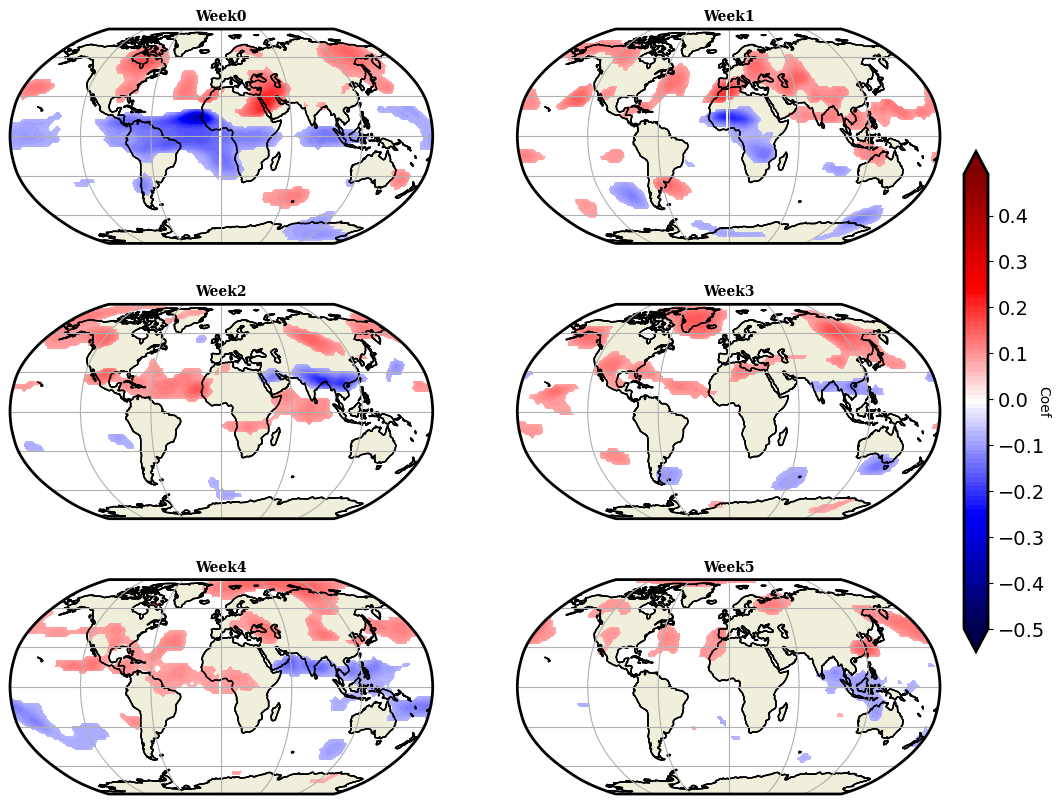

In [31]:
# Define the caracteristics of the plot
f = plt.figure(figsize=(12,10))                                                   # create a figure and define its size
f.subplots_adjust(right = 0.9, bottom = 0.1, hspace= 0.2,wspace=0.2)               # adjust the space between subplots
axs = []
for i in range(6) :
    ax = f.add_subplot(3,2,i+1,projection=ccrs.Robinson(0))                      # the figure will be composed of 3x3 maps
    ax.coastlines()                                                                # add the coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree())#, draw_labels=True)                    # add the longitude / latitude lines
    #gl.right_labels = False                                                        # remove latitude labels on the right
    #gl.top_labels = False                                                          # remove longitude labels on the top
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')                         # add land mask
    axs.append(ax)
month = ['Week0','Week1','Week2','Week3','Week4','Week5']
step_arrows = [gp500_0_days,gp500_7_days,gp500_14_days,gp500_21_days,gp500_28_days,gp500_35_days]
#step_arrows = [delai_0days_WA, delai_7days_WA, delai_14days_WA, delai_21days_WA, delai_28days_WA]
for i in range(len(step_arrows)):
    date = step_arrows[i]    
    #date = start_date + i
    [correD,pvalueD,csig,reg,reg_sig]=IndexRegression(date,Index_rain_SNG[:],0.05)
    #precip = np.squeeze(pre_all[i,:,:])
    axs[i].set_global()
    im = axs[i].contourf(lon,lat,csig.reshape(len(lat),len(lon)),cmap='seismic', levels=np.arange(-0.5,0.5,0.01),extend='both',transform = ccrs.PlateCarree())
    # add the date in the map titles 
    #axs[i].set_title(np.datetime_as_string(date,unit='m'))
    axs[i].set_title(month[i],fontsize=10, weight='bold',family = 'serif')
    axs[i].coastlines()
    #axs[i].add_feature(cfeat.COASTLINE,edgecolor = 'k')
    #axs[i].add_feature(cfeat.BORDERS, linestyle='-',alpha=1)#Ajouter dans les shapefiles des pays

# Add the titles and legend
#f.suptitle('Figure 1 distribution spatiale des précipitations en juin, juillet, août et septembre en AO sur la période 1981 à 2018',fontsize=14, weight='bold',family = 'serif',y=0.08)                 # add a title to the figure
#axs.set_title('csig_gp500_rain_22_Aout',fontsize=18,weight='bold')
cbar_ax = f.add_axes([0.92, 0.25, 0.02, 0.5])                                       # define the colorbar location
cbar =f.colorbar(im,cax=cbar_ax)                                                   # display the colorbar
cbar.set_label('Coef', rotation=270,fontsize=10)                             # add the title of the colorbar

# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/csig_ISO_gp500_Anom_rain_hebdomadaire.png', bbox_inches='tight')
plt.show()

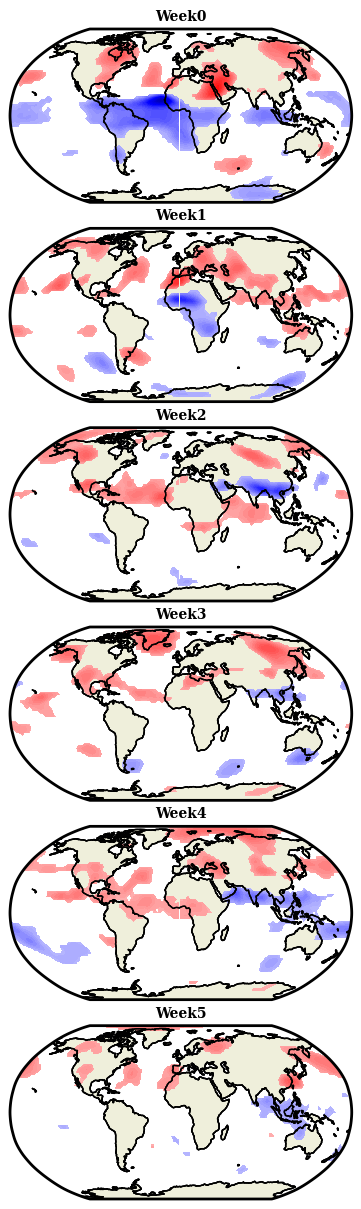

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the characteristics of the plot
f = plt.figure(figsize=(8, 15))  # define figure size for a single column layout
f.subplots_adjust(right=0.85, bottom=0.1, hspace=0.15)  # adjust space between subplots

axs = []
for i in range(6):
    ax = f.add_subplot(6, 1, i + 1, projection=ccrs.Robinson(central_longitude=0))  # 6 rows, 1 column
    ax.coastlines()  # add coastlines
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)  # add lat/lon gridlines
    #gl.right_labels = False  # remove latitude labels on the right
    #gl.top_labels = False  # remove longitude labels on the top
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')  # add land mask
    axs.append(ax)

# Set the titles and data for each subplot
month = ['Week0', 'Week1', 'Week2', 'Week3', 'Week4', 'Week5']
step_arrows = [gp500_0_days, gp500_7_days, gp500_14_days, gp500_21_days, gp500_28_days, gp500_35_days]

for i in range(len(step_arrows)):
    date = step_arrows[i]
    correD, pvalueD, csig, reg, reg_sig = IndexRegression(date, Index_rain_SNG[:], 0.05)
    axs[i].set_global()
    im = axs[i].contourf(lon, lat, csig.reshape(len(lat), len(lon)), cmap='seismic', levels=np.arange(-0.5, 0.5, 0.01), extend='both', transform=ccrs.PlateCarree())
    axs[i].set_title(month[i], fontsize=10, weight='bold', family='serif')
    axs[i].coastlines()

# Add colorbar
#cbar_ax = f.add_axes([0.88, 0.3, 0.02, 0.4])  # define colorbar location for single column layout
#cbar = f.colorbar(im, cax=cbar_ax)  # display colorbar
#cbar.set_label('csig_gp200_rain_weekly', rotation=270, fontsize=10)  # colorbar label

# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/csig_ISO_gp500_Anom_rain_hebdomadaire_colonnes.png', bbox_inches='tight')
plt.show()

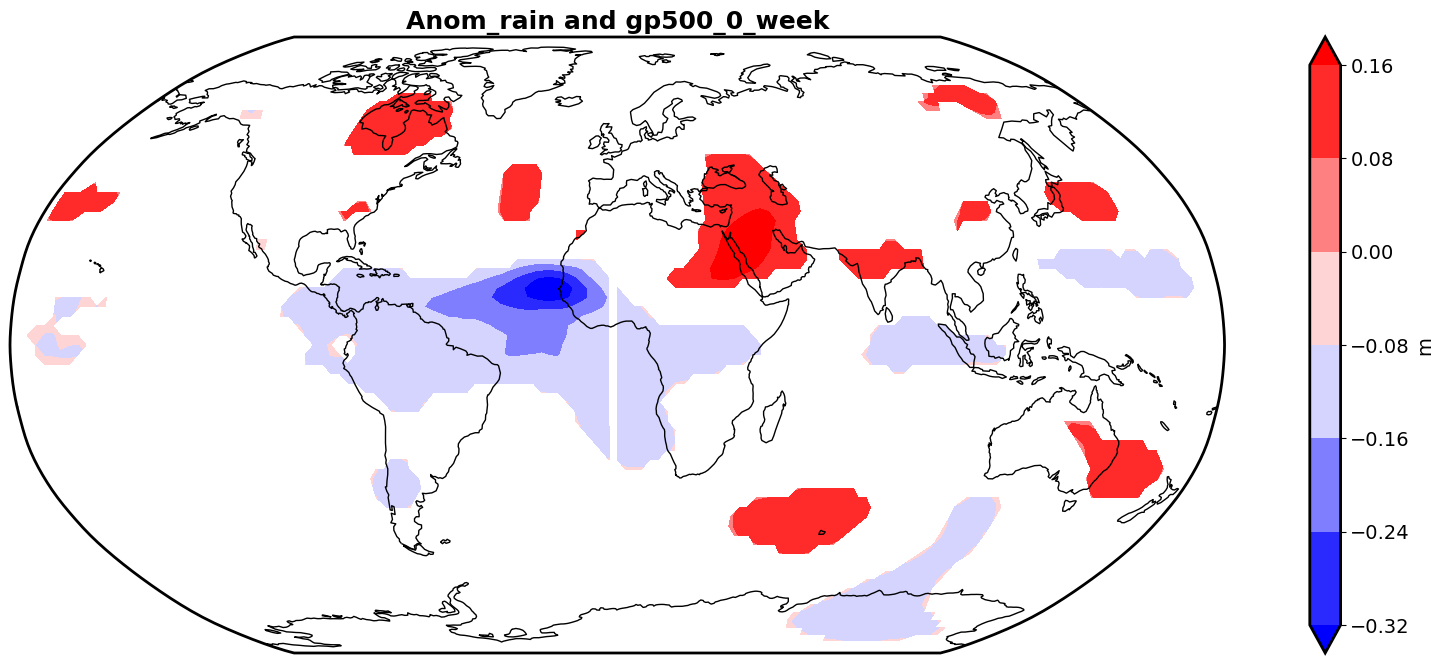

In [39]:
#plot just one map to see if everything is ok
fig = plt.figure(figsize=(22,8)) 
i=1
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(0))

[correD,pvalueD,csig,reg,reg_sig]=IndexRegression(gp500_0_days,Index_rain_SNG[:],0.05)
im = ax.contourf(lon,lat,csig.reshape(len(lat),len(lon)),cmap='bwr',
                 extend='both',transform = ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
fig.colorbar(im,ax=ax,label='m') #Para la barra de colores
ax.grid()
ax.set_title('Anom_rain and gp500_0_week',fontsize=18,weight='bold')
ax.set_ylabel('Lat',fontsize=14)
ax.set_xlabel('lon',fontsize=14);
#plt.savefig('/usr/home/dfaye/SST/ISO_gp500_Hebdomadaire.png',format='png'
#            , bbox_inches='tight')
plt.show(i)
time.sleep(2)

In [25]:
def covariance(x, y):
    [n1,n2]=x.shape
    Cov=ma.empty([n1,])
    for nn in range(n1):
        xx = x[nn,:]-np.nanmean(x[nn,:])
        yy = y-np.nanmean(y)
        zz = 1/float(len(x[nn,:]))
        cov=zz*np.sum(xx*yy)
        Cov[nn]=cov
    return Cov

In [26]:
def somme(x, y):
    [n1,n2]=y.shape
    Summ=ma.empty([n2,])
    for nn in range(n2):
        som=np.sum(x*y[:,nn])
        Summ[nn]=som
    return Summ

In [27]:
#[correD,pvalueD,csig,reg,reg_sig]=IndexRegression(gp500_0_days,Index_rain_SNG[:],0.05)
#delai_0days=csig
Cov_0days=covariance(gp500_0_days,Index_rain_SNG)
preduct_0d=somme(Cov_0days,gp500_0_days)

In [28]:
Cov_7days=covariance(gp500_7_days,Index_rain_SNG)
preduct_7d=somme(Cov_7days,gp500_7_days)

In [29]:
Cov_14days=covariance(gp500_14_days,Index_rain_SNG)
preduct_14d=somme(Cov_14days,gp500_14_days)

In [30]:
Cov_21days=covariance(gp500_21_days,Index_rain_SNG)
preduct_21d=somme(Cov_21days,gp500_21_days)

In [31]:
Cov_28days=covariance(gp500_28_days,Index_rain_SNG)
preduct_28d=somme(Cov_28days,gp500_28_days)

In [32]:
Cov_35days=covariance(gp500_35_days,Index_rain_SNG)
preduct_35d=somme(Cov_35days,gp500_35_days)

In [33]:
weekly_gp500_0d=np.array(preduct_0d)
weekly_gp500_7d=np.array(preduct_7d)
weekly_gp500_14d=np.array(preduct_14d)
weekly_gp500_21d=np.array(preduct_21d)
weekly_gp500_28d=np.array(preduct_28d)
weekly_gp500_35d=np.array(preduct_35d)

In [34]:
#weekly_gp200_0d.shape

In [35]:
np.save('/home/wester/Desktop/SST/ERA5/preduct_0d_weekly_gp500.npy',weekly_gp500_0d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_7d_weekly_gp500.npy',weekly_gp500_7d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_14d_weekly_gp500.npy',weekly_gp500_14d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_21d_weekly_gp500.npy',weekly_gp500_21d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_28d_weekly_gp500.npy',weekly_gp500_28d)
np.save('/home/wester/Desktop/SST/ERA5/preduct_35d_weekly_gp500.npy',weekly_gp500_35d)

In [36]:
preduct_0da=(preduct_0d - np.nanmean(preduct_0d))/np.nanstd(preduct_0d)
preduct_7da=(preduct_7d - np.nanmean(preduct_7d))/np.nanstd(preduct_7d)
preduct_14da=(preduct_14d - np.nanmean(preduct_14d))/np.nanstd(preduct_14d)
preduct_21da=(preduct_21d - np.nanmean(preduct_21d))/np.nanstd(preduct_21d)
preduct_28da=(preduct_28d - np.nanmean(preduct_28d))/np.nanstd(preduct_28d)
preduct_35da=(preduct_35d - np.nanmean(preduct_35d))/np.nanstd(preduct_35d)
Index_rain=(Index_rain_SNG- np.nanmean(Index_rain_SNG))/np.nanstd(Index_rain_SNG)

# Création des modéles de Machine Learning

In [37]:
GP500_0d=np.load('/home/wester/Desktop/SST/ERA5/preduct_0d_weekly_gp500.npy')
GP500_7d=np.load('/home/wester/Desktop/SST/ERA5/preduct_7d_weekly_gp500.npy')
GP500_14d=np.load('/home/wester/Desktop/SST/ERA5/preduct_14d_weekly_gp500.npy')
GP500_21d=np.load('/home/wester/Desktop/SST/ERA5/preduct_21d_weekly_gp500.npy')
GP500_28d=np.load('/home/wester/Desktop/SST/ERA5/preduct_28d_weekly_gp500.npy')
GP500_35d=np.load('/home/wester/Desktop/SST/ERA5/preduct_35d_weekly_gp500.npy')

In [38]:
GP500_0da=np.reshape(GP500_0d,[1,662])
GP500_7da=np.reshape(GP500_7d,[1,662])
GP500_14da=np.reshape(GP500_14d,[1,662])
GP500_21da=np.reshape(GP500_21d,[1,662])
GP500_28da=np.reshape(GP500_28d,[1,662])
GP500_35da=np.reshape(GP500_35d,[1,662])

In [39]:
GP500_0da.shape

(1, 662)

In [40]:
fname = '/home/wester/Desktop/SST/index_10_60d_rainfall_weekly_JJAS_1982-2019.nc'
ds = xr.open_dataset(fname)
Rain = ds['__xarray_dataarray_variable__'].data
Rain.shape

(662, 100, 140)

In [41]:
index_10_60d=np.reshape(Rain,[662,100*140])

**Dans cette étude**, les signaux ISO des champs atmosphériques et de l'anomalie de précipitaton sont normalisés en utilisant la méthode de **(Yeo et Johnson, 2000)**.

Le calcul des **signaux ISO** a généré des données comprenant à la fois des valeurs positives et négatives. C'est pourquoi nous avons choisi **la transformation de Yeo-Johnson**, qui permet de prendre en compte les valeurs négatives présentes dans les données.


**Dans les modèles de machine learning**, on peut souvent être amené à transformer les variables pour avoir des distributions normales.

# La transformation de Yeo-Johnson

La transformation de Yeo-Johnson est une technique similaire à la transformation de Box-Cox, mais elle **peut être utilisée pour des distributions non normales et avec des valeurs négatives**. Yeo-Johnson **applique une transformation qui est une combinaison de la transformation de puissance et de la transformation logarithmique**. Comme pour Box-Cox, l'algorithme choisit automatiquement la transformation optimale pour maximiser la vraisemblance.

La formule de la transformation de Yeo-Johnson est la suivante :

$$
y(\lambda) =
\begin{cases}
\frac{(y+1)^\lambda - 1}{\lambda} & \text{si } y \geq 0, \lambda \neq 0 \\
\log(y+1) & \text{si } y \geq 0, \lambda = 0 \\
-\frac{(-y+1)^{2-\lambda}-1}{2-\lambda} & \text{si } y < 0, \lambda \neq 2 \\
-\log(-y+1) & \text{si } y < 0, \lambda = 2
\end{cases}
$$

où y est la variable à transformer et lambda est la valeur qui maximise la vraisemblance.

### Avantages de la transformation de Yeo-Johnson

- Peut être utilisée pour des distributions non normales et avec des valeurs négatives.
- Comme pour Box-Cox, la valeur optimale de lambda est choisie automatiquement pour maximiser la vraisemblance.

### Inconvénients de la transformation de Yeo-Johnson

- Peut être plus lente à calculer que la transformation de Box-Cox.
- La transformation peut être instable pour certaines valeurs de lambda.

In [42]:
from sklearn.preprocessing import PowerTransformer
# Initialiser un objet PowerTransformer avec la méthode de Yeo-Johnson
yeo_johnson = PowerTransformer(method='yeo-johnson')

In [43]:
Rain_Index=yeo_johnson.fit_transform(index_10_60d)

In [44]:
#Precip_yeo

In [45]:
aa0=np.transpose(GP500_0da)
aa7=np.transpose(GP500_7da)
aa14=np.transpose(GP500_14da)
aa21=np.transpose(GP500_21da)
aa28=np.transpose(GP500_28da)
aa35=np.transpose(GP500_35da)

In [46]:
aa35.shape

(662, 1)

In [47]:
delai_0days= yeo_johnson.fit_transform(aa0)
delai_7days= yeo_johnson.fit_transform(aa7)
delai_14days= yeo_johnson.fit_transform(aa14)
delai_21days= yeo_johnson.fit_transform(aa21)
delai_28days= yeo_johnson.fit_transform(aa28)
delai_35days= yeo_johnson.fit_transform(aa35)

In [48]:
lead_time=[delai_0days,delai_7days,delai_14days,delai_21days,delai_28days,delai_35days]

In [49]:
rain_Index=np.squeeze(yeo_johnson.fit_transform(np.reshape(Index_rain_SNG,[662,1])))

In [50]:
rain_Index.shape

(662,)

In [51]:
#weekly_rain_SNG

In [52]:
Rain_Index[np.isnan(Rain_Index)]=0

In [53]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

In [54]:
# Fonction pour calculer le coefficient de corrélation avec gestion des NaN
def correlation_coefficient(y_true, y_pred):
    if np.var(y_true) == 0 or np.var(y_pred) == 0:
        return 0  # Si la variance est nulle, la corrélation est 0
    else:
        return pearsonr(y_true, y_pred)[0]

In [55]:
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
n_jobs = -1
# Nombre total de semaines (662) et les 17 semaines de validation par an
total_weeks = 662
weeks_per_year = 17
n_splits = total_weeks // weeks_per_year  # Le nombre de splits

# Créer un split de validation croisée en série temporelle
ts_cv = TimeSeriesSplit(n_splits=n_splits)
# Définition des scores à utiliser pour la validation croisée
scoring_mae = make_scorer(mean_absolute_error)
scoring_corr = make_scorer(correlation_coefficient)
n_jobs = -1

# La régression Ridge

In [56]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

In [65]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Création d'un objet Ridge Regression
Reg_R = Ridge()

# Paramètres à tester pour la recherche de grille
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Définition du score à utiliser pour la recherche de grille
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Dictionnaire pour stocker les scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Recherche de grille et validation croisée en une étape
    grid_search = GridSearchCV(Reg_R, param_grid=param_grid, cv=ts_cv, n_jobs=n_jobs, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle trouvé par GridSearchCV pour ce délai
    best_model = grid_search.best_estimator_
    
    # Obtenir les scores avec cross_val_score en utilisant le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(mean_absolute_error))
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    
    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    #print(f'Best alpha for {name}:', grid_search.best_params_['alpha'])
    print(f'Mean MAE for {name}:', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop500_0-35days_Ridge.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp500_0-35days_Ridge.npy', S2S_corr)

Mean MAE for 0days: 0.7627125145317143
Mean Correlation for 0days: 0.2397136787843623
Mean MAE for 7days: 0.7671665224251356
Mean Correlation for 7days: 0.22046243708313307
Mean MAE for 14days: 0.7757004699679527
Mean Correlation for 14days: 0.2462104970776658
Mean MAE for 21days: 0.763287213413998
Mean Correlation for 21days: 0.2558523018674188
Mean MAE for 28days: 0.7595064814322027
Mean Correlation for 28days: 0.27385249257649247
Mean MAE for 35days: 0.7625288352177072
Mean Correlation for 35days: 0.2579582856550204


# Modèle de régression Linéaire

In [66]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression

In [67]:
from sklearn.metrics import mean_absolute_error
#from sklearn.model_selection import make_scorer
from sklearn.metrics import mean_absolute_error, make_scorer

In [68]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Création d'un objet Linear Regression
Reg_LR = LinearRegression()

# Définition du score à utiliser pour la validation croisée
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []
# Boucle sur chaque délai pour effectuer la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer la validation croisée
    scores = cross_val_score(Reg_LR, delai, rain_Index, cv=ts_cv, scoring=scoring)
    
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    scores_corr = cross_val_score(Reg_LR, delai, rain_Index, cv=ts_cv, scoring=scoring_corr)
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name}:', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_gp500_0-35days_RL.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp500_0-35days_RL.npy', S2S_corr)

Mean MAE for 0days: 0.7627124781876364
Mean Correlation for 0days: 0.23971367878436226
Mean MAE for 7days: 0.7671664879278755
Mean Correlation for 7days: 0.22046243708313307
Mean MAE for 14days: 0.7757004654350833
Mean Correlation for 14days: 0.2462104970776658
Mean MAE for 21days: 0.7632871858625229
Mean Correlation for 21days: 0.2558523018674188
Mean MAE for 28days: 0.7596993096224796
Mean Correlation for 28days: 0.2738524925764925
Mean MAE for 35days: 0.7625288189231147
Mean Correlation for 35days: 0.2579582856550204


# Support-vector-regression

In [69]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Création d'un objet SVR
Reg_SVR = SVR()

# Définition des paramètres à tester pour la recherche de grille
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Définition du score à utiliser pour la recherche de grille
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les meilleurs scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer une recherche de grille pour trouver les meilleurs hyperparamètres pour chaque délai
    grid_search = GridSearchCV(Reg_SVR, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle avec les hyperparamètres optimaux
    best_model = grid_search.best_estimator_
    
    # Validation croisée avec le meilleur modèle pour chaque délai
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop500_0-35days_SVR.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp500_0-35days_SVR.npy', S2S_corr)

Mean MAE for 0days (best model): 0.7772437896645047
Mean Correlation for 0days: 0.1558470699115041
Mean MAE for 7days (best model): 0.8026726400692308
Mean Correlation for 7days: 0.09021561457418996
Mean MAE for 14days (best model): 0.7923580397575892
Mean Correlation for 14days: 0.16904236707112558
Mean MAE for 21days (best model): 0.777124946723604
Mean Correlation for 21days: 0.20063691988029647
Mean MAE for 28days (best model): 0.7768853537552469
Mean Correlation for 28days: 0.2166909820636163
Mean MAE for 35days (best model): 0.790428477951084
Mean Correlation for 35days: 0.181773750880379


# Multi-layer Perceptron Regressor (MLPRegressor)

In [70]:
from sklearn.neural_network import MLPRegressor

# Création d'un objet MLP Regressor
Reg_MLP = MLPRegressor(max_iter=1000)

# Définition des paramètres pour la recherche de grille
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Utilisation du score MAE sans inversion de signe
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les meilleurs scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer une recherche de grille pour trouver les meilleurs hyperparamètres pour chaque délai
    grid_search = GridSearchCV(Reg_MLP, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle avec les hyperparamètres optimaux
    best_model = grid_search.best_estimator_
    
    # Validation croisée avec le meilleur modèle pour chaque délai
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop500_0-35days_MLP.npy', S2S)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp500_0-35days_MLP.npy', S2S_corr)

Mean MAE for 0days (best model): 0.7655674376324396
Mean Correlation for 0days: 0.1948157706077255
Mean MAE for 7days (best model): 0.7764782386632856
Mean Correlation for 7days: 0.17617015461396035
Mean MAE for 14days (best model): 0.776071724914865
Mean Correlation for 14days: 0.24091029277358691
Mean MAE for 21days (best model): 0.7653348416227987
Mean Correlation for 21days: 0.2410268813154965
Mean MAE for 28days (best model): 0.7610021435791409
Mean Correlation for 28days: 0.26470301433277205
Mean MAE for 35days (best model): 0.76976918765548
Mean Correlation for 35days: 0.2336420866211112


# Random Forest avec GridSearchCV

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Définition de l'objet Random Forest Regressor
Reg_RF = RandomForestRegressor()

# Paramètres pour la recherche de grille
param_grid = {
    'n_estimators': [50, 100, 200],      # Nombre d'arbres dans la forêt
    'max_depth': [10, 20, None],         # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],     # Minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]        # Minimum d'échantillons dans chaque feuille
}

# Définition du score à utiliser pour l'évaluation
scoring = make_scorer(mean_absolute_error)

# Initialisation de la liste pour les scores moyens pour chaque délai
mean_scores_mae = []
mean_scores_corr = []
# Boucle pour chaque délai avec recherche de grille et validation croisée
for delai, name in zip(delais, delai_names):
    grid_search = GridSearchCV(Reg_RF, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    best_model = grid_search.best_estimator_

    # Calculer les scores MAE avec validation croisée pour le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les résultats
S2S_RF = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop500_0-35days_RF.npy', S2S_RF)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp500_0-35days_RF.npy', S2S_corr)

Mean MAE for 0days (best model): 0.8870557103476033
Mean Correlation for 0days: 0.10183942640357278
Mean MAE for 7days (best model): 0.8904782630295162
Mean Correlation for 7days: 0.06719563160086707
Mean MAE for 14days (best model): 0.912852540901094
Mean Correlation for 14days: 0.0674726814856295
Mean MAE for 21days (best model): 0.8897232444858268
Mean Correlation for 21days: 0.0879352463871588
Mean MAE for 28days (best model): 0.9028921313888365
Mean Correlation for 28days: 0.07073890597867749
Mean MAE for 35days (best model): 0.8725546453946297
Mean Correlation for 35days: 0.1401741136836753


# Modèle Adaboost

In [57]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Initialisation de l'objet AdaBoost Regressor
Reg_AB = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5))

# Paramètres pour la recherche de grille
param_grid = {
    'n_estimators': [100, 200, 300, 400],                    # Nombre d'estimateurs
    'learning_rate': [0.01, 0.1, 0.5, 1.0]              # Taux d'apprentissage
}

# Définition du score pour l'évaluation
scoring = make_scorer(mean_absolute_error)

# Liste pour les scores moyens pour chaque délai
mean_scores_mae = []
mean_scores_corr = []
# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']
# Boucle pour chaque délai avec recherche de grille et validation croisée
for delai, name in zip(delais, delai_names):
    grid_search = GridSearchCV(Reg_AB, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    best_model = grid_search.best_estimator_

    # Calculer les scores MAE avec validation croisée pour le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les résultats
S2S_AB = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_geop500_0-35days_Adaboost_1982-2019.npy', S2S_AB)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_gp500_0-35daysAdaboost_1982-2019..npy', S2S_corr)

Mean MAE for 0days (best model): 0.8215559962646015
Mean Correlation for 0days: 0.13552934205965977
Mean MAE for 7days (best model): 0.7983084453170809
Mean Correlation for 7days: 0.15753487541557734
Mean MAE for 14days (best model): 0.8446794717749234
Mean Correlation for 14days: 0.15671678148025125
Mean MAE for 21days (best model): 0.8172472174143994
Mean Correlation for 21days: 0.13521901901610864
Mean MAE for 28days (best model): 0.8148768666069226
Mean Correlation for 28days: 0.12273406029476835
Mean MAE for 35days (best model): 0.8059994961594391
Mean Correlation for 35days: 0.19506188243125877


# Pour voir la variabilité spatiale du scores

Pour intégrer GridSearchCV dans le calcul pour chaque point de grille et chaque délai, nous devons d'abord trouver les meilleurs hyperparamètres pour chaque délai en utilisant GridSearchCV puis les appliquer dans la boucle pour chaque point de grille.

In [88]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Paramètres pour la recherche de grille
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
scoring = make_scorer(mean_absolute_error)

# Trouver les meilleurs paramètres pour chaque délai
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
best_alphas = []

for delai in delais:
    grid_search = GridSearchCV(Ridge(), param_grid=param_grid, cv=ts_cv, scoring=scoring)
    grid_search.fit(delai, Rain_Index)
    best_alphas.append(grid_search.best_params_['alpha'])

# Initialisation des listes pour stocker les scores pour chaque délai et chaque point de grille
score_0d, score_7d, score_14d, score_21d, score_28d, score_35d = [], [], [], [], [], []

# Boucle pour chaque point de grille
for i in range(len(Rain_Index[1])):
    # Calculer les scores de validation croisée avec les meilleurs alphas pour chaque délai
    score_0da = cross_val_score(Ridge(alpha=best_alphas[0]), delai_0days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_7da = cross_val_score(Ridge(alpha=best_alphas[1]), delai_7days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_14da = cross_val_score(Ridge(alpha=best_alphas[2]), delai_14days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_21da = cross_val_score(Ridge(alpha=best_alphas[3]), delai_21days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_28da = cross_val_score(Ridge(alpha=best_alphas[4]), delai_28days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)
    score_35da = cross_val_score(Ridge(alpha=best_alphas[5]), delai_35days, Rain_Index[:, i], cv=ts_cv, scoring=scoring)

    # Stocker les scores dans les listes correspondantes
    score_0d.append(score_0da)
    score_7d.append(score_7da)
    score_14d.append(score_14da)
    score_21d.append(score_21da)
    score_28d.append(score_28da)
    score_35d.append(score_35da)

# Calcul de la moyenne des scores pour chaque délai
mean_score_0d = np.mean(score_0d, axis=1)
mean_score_7d = np.mean(score_7d, axis=1)
mean_score_14d = np.mean(score_14d, axis=1)
mean_score_21d = np.mean(score_21d, axis=1)
mean_score_28d = np.mean(score_28d, axis=1)
mean_score_35d = np.mean(score_35d, axis=1)

In [89]:
mean_score_0d[mean_score_0d == 0.] = np.nan
mean_score_7d[mean_score_7d == 0.] = np.nan
mean_score_14d[mean_score_14d == 0.] = np.nan
mean_score_21d[mean_score_21d == 0.] = np.nan
mean_score_28d[mean_score_28d == 0.] = np.nan
mean_score_35d[mean_score_35d == 0.] = np.nan
# Enregistrement des résultats dans un fichier .npy
S2S = [mean_score_0d, mean_score_7d, mean_score_14d, mean_score_21d, mean_score_28d, mean_score_35d]
np.save('/home/wester/Desktop/SST/models_spatial/mae_anom_rainfall_geop500_0-35days_Ridge_grid.npy', S2S)